# Projet numérique : lignes de niveau

In [6]:
import autograd
from autograd import numpy as np
import matplotlib.pyplot as plt

Exemples de fonction qui nous permettront de tester nos algorithmes :

In [7]:
def f(x,y):
    return(x**2+y**2)

def g(x,y):
    return(2*x**2+3*y)

def h(x,y):
    return(np.exp(x+y))

## Contour simple

### Amorce

D'après le théorème des valeurs intermédiaires, et par continuité de $y \rightarrow f(0,y)$, si $f(0,1) \leq c \leq f(0,0)$ ou $f(0,0) \leq c \leq f(0,1)$, alors il existe t tel que $f(0,t)=c$.
Si cette condition est remplie, on peut approcher la solution t par dichotomie.

In [8]:
def find_seed(g,c=0,eps=2**(-26)):
    a,b=0,1
    if ((g(0,1)<=c<=g(0,0)) or (g(0,0)<=c<=g(0,1))):
        while (b-a)>eps:
            if g(0,(b+a)/2)>c:
                b=(b+a)/2
            else:
                a=(b+a)/2
        return((b+a)/2)
    else:
        return None    

In [9]:
def find_seed_newton(g,c=0.0,eps=2**(-26)):
    init=0.1
    if ((g(0,1)<=c<=g(0,0)) or (g(0,0)<=c<=g(0,1))):
        def f(y):
            return(g(0,y)-c)
        Y=[init,-f(init)/autograd.grad(f)(init)]
        k=0
        while abs(Y[k]-Y[k+1])>eps :
            Y.append(Y[k]-(f(Y[k]))/autograd.grad(f)(Y[k]))
            k+=1
        return Y[-1]
    else:
        return None

#### Comparaison des deux algorithmes en précision et en rapidité

In [10]:
print(find_seed(f,0.25)-0.5)
print(find_seed_newton(f,0.25)-0.5)

print(find_seed(g,0.3)-0.1)
print(find_seed_newton(g,0.3)-0.1)

print(find_seed(h,2)-np.log(2.0))
print(find_seed_newton(h,2.0)-np.log(2.0))

7.450580596923828e-09
5.37225819385867e-12
1.4901161138336505e-09
0.0
-5.545926273775592e-09
4.440892098500626e-16


L'algorithme qui utilise la méthode de Newton a dans chacun des cas testés une bien meilleure précision.

In [11]:
import time

start_time = time.time()
find_seed(f,0.25)
print("Temps d execution : %s secondes ---" % (time.time() - start_time))

start_time = time.time()
find_seed_newton(f,0.1)
print("Temps d execution : %s secondes ---" % (time.time() - start_time))

start_time = time.time()
find_seed(g,0.3)
print("Temps d execution : %s secondes ---" % (time.time() - start_time))

start_time = time.time()
find_seed_newton(g,0.3)
print("Temps d execution : %s secondes ---" % (time.time() - start_time))

start_time = time.time()
find_seed(h,2.0)
print("Temps d execution : %s secondes ---" % (time.time() - start_time))

start_time = time.time()
find_seed_newton(h,2.0)
print("Temps d execution : %s secondes ---" % (time.time() - start_time))

Temps d execution : 0.0009965896606445312 secondes ---
Temps d execution : 0.005000591278076172 secondes ---
Temps d execution : 0.0 secondes ---
Temps d execution : 0.0009906291961669922 secondes ---
Temps d execution : 0.0 secondes ---
Temps d execution : 0.004926204681396484 secondes ---


La méthode par dichotomie est dans chacun des exemples plus rapide (facteur 10) que la méthode de Newton. 

### Propagation

**Propriété 1:**
Soit $E$ un espace euclidien.
Soit $U$ un ouvert de $E$ et $f:U\rightarrow \mathbb{R}$ différentiable en $a \in U$
Soit $X$ la ligne de niveau de $f$ passant par a. $X=\{x \in U / f(x)=a\}$
Soit $h \in E$.
Si h est tangent à $X$, alors $\langle h,\vec{\mathrm{grad}}f(a) \rangle = 0$

On utilise cette propriété pour trouver à chaque étape un vecteur tangent à la ligne de niveau et on avance de \delta dans cette direction

In [12]:
def tang_norm(f,x,y,delta=0.01):
    """retourne un vecteur, de norme delta, orthogonal au gradient de f en (x,y), donc tangent à la ligne de niveau de f en (x,y)"""
    g=autograd.grad
    normed=delta/((g(f,0)(x,y)**2+g(f,1)(x,y)**2)**(0.5))
    return np.r_[g(f,1)(x,y)*normed,-g(f,0)(x,y)*normed]

tang_norm(f,0.0,0.5)


array([ 0.01, -0.  ])

In [13]:
def simple_contour_naif(f,c=0.0,d=0.01):
    eps=2**(-25)
    x,y=[],[]
    t=find_seed(f,c)
    if isinstance(t,float):
        x.append(0.0)
        y.append(t)
        (xi,yi)=(0.0,t)+tang_norm(f,0.0,t,d)
        while (xi>eps and (1-eps)>xi and yi>eps and (1-eps)>yi):
            x.append(xi)
            y.append(yi)
            (xi,yi)=(xi,yi)+tang_norm(f,xi,yi,d)
        return (np.array(x),np.array(y))
    else:
        return (np.array(x),np.array(x))

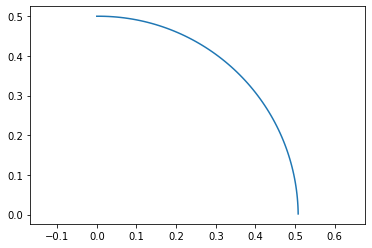

In [14]:
X,Y=simple_contour_naif(f,0.25,0.01)
plt.plot(X,Y)
plt.axis("equal")
plt.show()

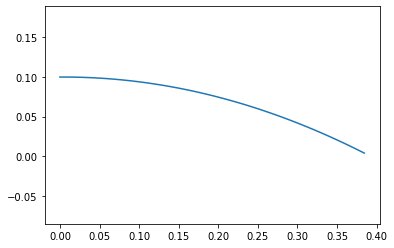

In [15]:
X,Y=simple_contour_naif(g,0.3,0.01)
plt.plot(X,Y)
plt.axis("equal")
plt.show()

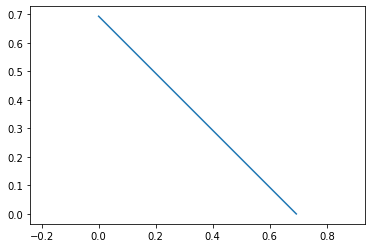

In [16]:
X,Y=simple_contour_naif(h,2.0,0.01)
plt.plot(X,Y)
plt.axis("equal")
plt.show()

In [60]:
def Jac(f,x,y):
    j=autograd.jacobian
    return np.c_[j(f,0)(x,y),j(f,1)(x,y)]

In [62]:
def recherche_point_newton(f,xi,yi,d,c,eps):
    
    def F(x,y):
        return np.array([f(x,y)-c,(x-xi)**2+(y-yi)**2-d**2])
    
    (x,y)=(xi,yi)+tang_norm(f,xi,yi,d)
    
    while F(x,y)[0]**2+F(x,y)[1]**2 > eps**2:
        J=Jac(F,x,y)
        (x,y)=(x,y)-np.dot(np.linalg.inv(J),F(x,y))
        
    return (x,y)

In [63]:
def simple_contour(f,c=0.0,d=0.01):
    eps=2**(-25)
    x,y=[],[]
    t=find_seed(f,c)
    if isinstance(t,float):
        x.append(0.0)
        y.append(t)
        (xi,yi)=recherche_point_newton(f,0.0,t,d,c,eps)
        x.append(xi)
        y.append(yi)
        while (xi>eps and (1-eps)>xi and yi>eps and (1-eps)>yi):
            (xi,yi)=recherche_point_newton(f,xi,yi,d,c,eps)
            x.append(xi)
            y.append(yi)
        return (np.array(x),np.array(y))
    else:
        return (np.array(x),np.array(x))

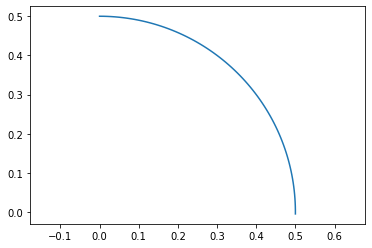

In [84]:
X,Y=simple_contour(f,c=0.25)
plt.plot(X,Y)
plt.axis("equal")
plt.show()

## Contour complexe

In [66]:
def find_seed_cellule (g,c,i,j,xc,yc,eps=2**-26):
    seeds=[]
    
    for k in range (0,2):
        a,b=yc[j],yc[j+1]
        if ((g(xc[i+k],yc[j])<=c<=g(xc[i+k],yc[j+1])) or (g(xc[i+k],yc[j+1])<=c<=g(xc[i+k],yc[j]))):
            while (b-a)>eps:
                if g(0,(b+a)/2)>c:
                    b=(b+a)/2
                else:
                    a=(b+a)/2
            seeds.append((xc[i+k],(b+a)/2))
        
        a,b=xc[i],xc[i+1]
        if ((g(xc[i],yc[j+k])<=c<=g(xc[i+1],yc[j+k])) or (g(xc[i+1],yc[j+k])<=c<=g(xc[i],yc[j+k]))):
            while (b-a)>eps:
                if g(0,(b+a)/2)>c:
                    b=(b+a)/2
                else:
                    a=(b+a)/2
            seeds.append(((b+a)/2,yc[j+k]))
            
    return seeds

In [72]:
def contour_complexe (g,c=0.0,xc=[0.0,1.0],yc=[0.0,1.0],d=0.01):
    xs,ys=[],[]
    for i in range (0,len(xc)-1):
        for j in range (0,len(yc)-1):
            seeds=find_seed_cellule (g,c,i,j,xc,yc)
            for (tx,ty) in seeds:
                eps=2**(-35)
                xs.append(tx)
                ys.append(ty)
                (xi,yi)=(tx,ty)+tang_norm(f,tx,ty,d)
                while (xi>eps and (1-eps)>xi and yi>eps and (1-eps)>yi):
                    xs.append(xi)
                    ys.append(yi)
                    (xi,yi)=(xi,yi)+tang_norm(f,xi,yi,d)
    return (np.array(xs),np.array(ys))

In [82]:
xc,yc=[-1.0,0.0,1.0],[-1.0,0.0,1.0]

contour_complexe (f,0.25,xc,yc)

(array([ 0.00000000e+00, -7.45058060e-09, -7.45058060e-09,  0.00000000e+00,
         1.00000000e-02,  1.99980006e-02,  2.99900054e-02,  3.99720228e-02,
         4.99400675e-02,  5.98901623e-02,  6.98183395e-02,  7.97206425e-02,
         8.95931273e-02,  9.94318644e-02,  1.09232940e-01,  1.18992457e-01,
         1.28706538e-01,  1.38371326e-01,  1.47982986e-01,  1.57537705e-01,
         1.67031697e-01,  1.76461200e-01,  1.85822483e-01,  1.95111842e-01,
         2.04325603e-01,  2.13460127e-01,  2.22511807e-01,  2.31477070e-01,
         2.40352380e-01,  2.49134241e-01,  2.57819194e-01,  2.66403819e-01,
         2.74884741e-01,  2.83258625e-01,  2.91522183e-01,  2.99672170e-01,
         3.07705390e-01,  3.15618693e-01,  3.23408980e-01,  3.31073201e-01,
         3.38608359e-01,  3.46011508e-01,  3.53279757e-01,  3.60410269e-01,
         3.67400263e-01,  3.74247015e-01,  3.80947861e-01,  3.87500192e-01,
         3.93901462e-01,  4.00149185e-01,  4.06240937e-01,  4.12174356e-01,
         4.1

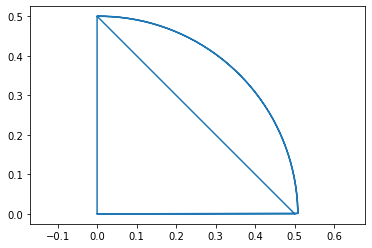

In [83]:
X,Y=contour_complexe (f,0.25,xc,yc)
plt.plot(X,Y)
plt.axis("equal")
plt.show()